In [14]:
!pip install nilearn

In [15]:
!pip install nibabel

In [16]:
!pip install --upgrade "imageio>=2.33,<2.35.0"


In [18]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
#!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif
#import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras import layers



# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [19]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

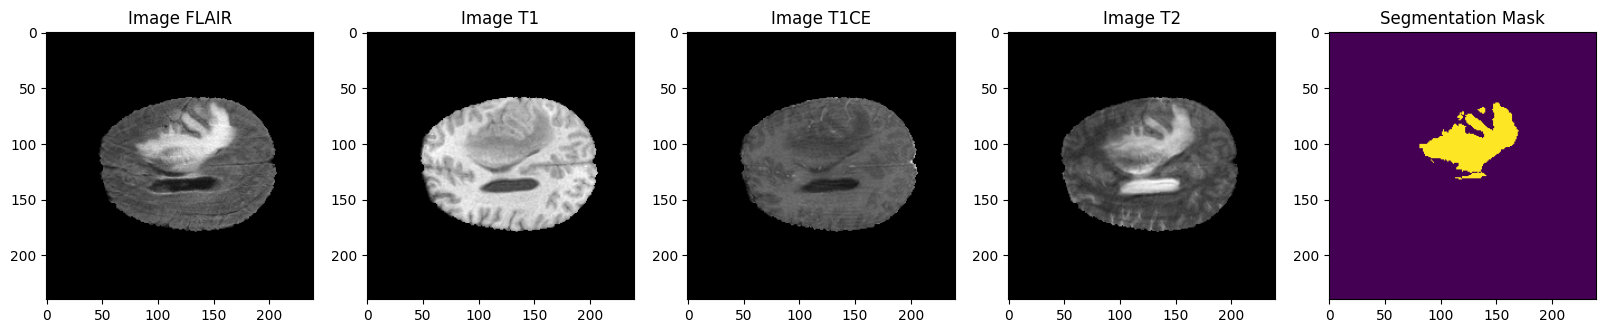

In [20]:
TRAIN_DATASET_PATH = r"C:\Users\Niran\Datasets\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"
VALIDATION_DATASET_PATH = r"C:\Users\Niran\Datasets\BraTS2020_ValidationData\MICCAI_BraTS2020_ValidationData"

# ✅ Load MRI modalities and mask for case BraTS20_Training_001
test_image_flair = nib.load(f"{TRAIN_DATASET_PATH}\\BraTS20_Training_001\\BraTS20_Training_001_flair.nii").get_fdata()
test_image_t1 = nib.load(f"{TRAIN_DATASET_PATH}\\BraTS20_Training_001\\BraTS20_Training_001_t1.nii").get_fdata()
test_image_t1ce = nib.load(f"{TRAIN_DATASET_PATH}\\BraTS20_Training_001\\BraTS20_Training_001_t1ce.nii").get_fdata()
test_image_t2 = nib.load(f"{TRAIN_DATASET_PATH}\\BraTS20_Training_001\\BraTS20_Training_001_t2.nii").get_fdata()
test_mask = nib.load(f"{TRAIN_DATASET_PATH}\\BraTS20_Training_001\\BraTS20_Training_001_seg.nii").get_fdata()

# ✅ Display middle slices
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
slice_w = 25

ax1.imshow(test_image_flair[:, :, test_image_flair.shape[0]//2 - slice_w], cmap='gray')
ax1.set_title('Image FLAIR')

ax2.imshow(test_image_t1[:, :, test_image_t1.shape[0]//2 - slice_w], cmap='gray')
ax2.set_title('Image T1')

ax3.imshow(test_image_t1ce[:, :, test_image_t1ce.shape[0]//2 - slice_w], cmap='gray')
ax3.set_title('Image T1CE')

ax4.imshow(test_image_t2[:, :, test_image_t2.shape[0]//2 - slice_w], cmap='gray')
ax4.set_title('Image T2')

ax5.imshow(test_mask[:, :, test_mask.shape[0]//2 - slice_w])
ax5.set_title('Segmentation Mask')

plt.show()


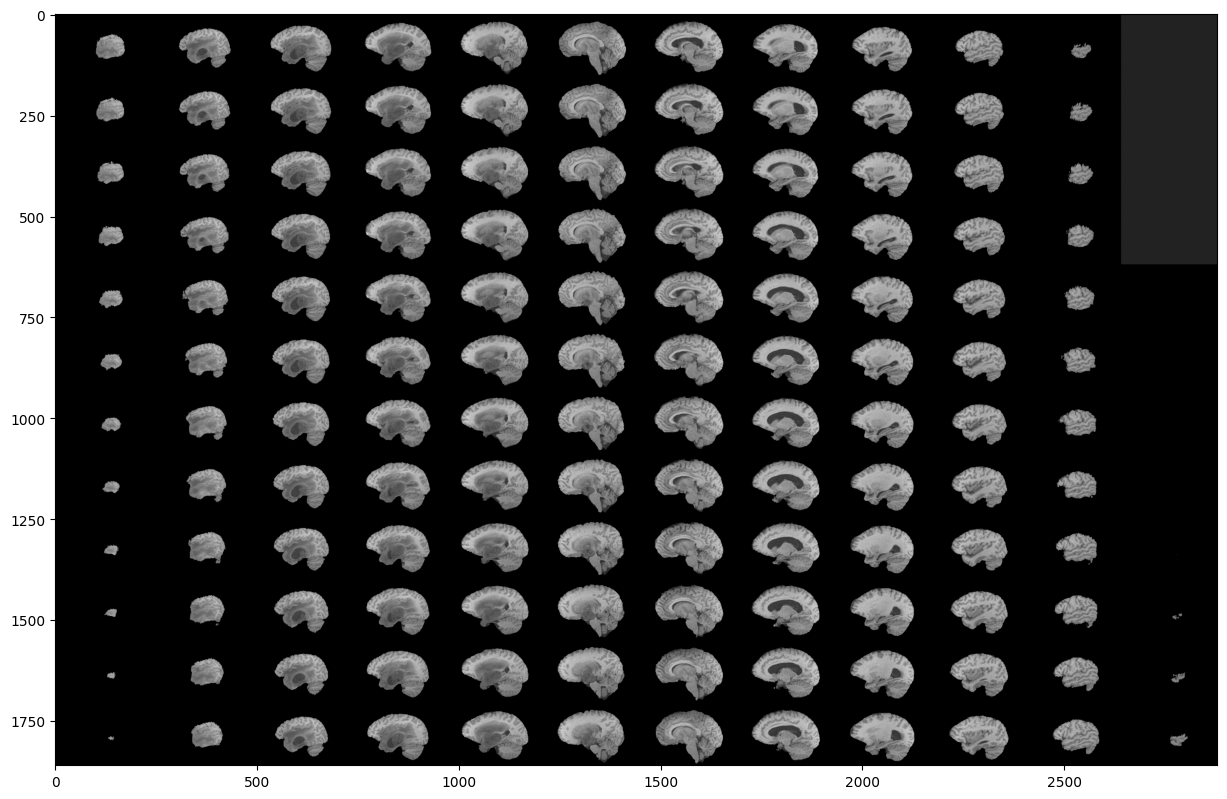

In [21]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

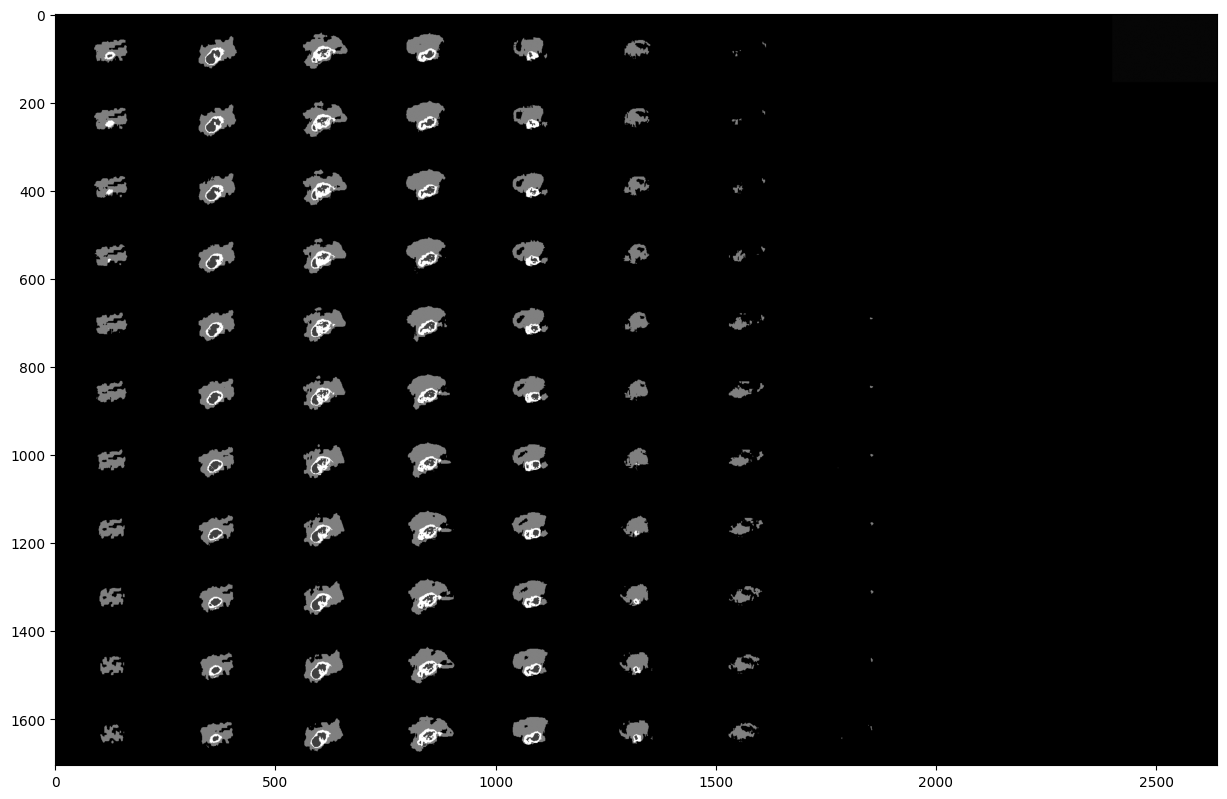

In [22]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [24]:
shutil.copy2(TRAIN_DATASET_PATH + r'\BraTS20_Training_001\BraTS20_Training_001_flair.nii','./test_gif_BraTS20_Training_001_flair.nii')
# gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')

'./test_gif_BraTS20_Training_001_flair.nii'

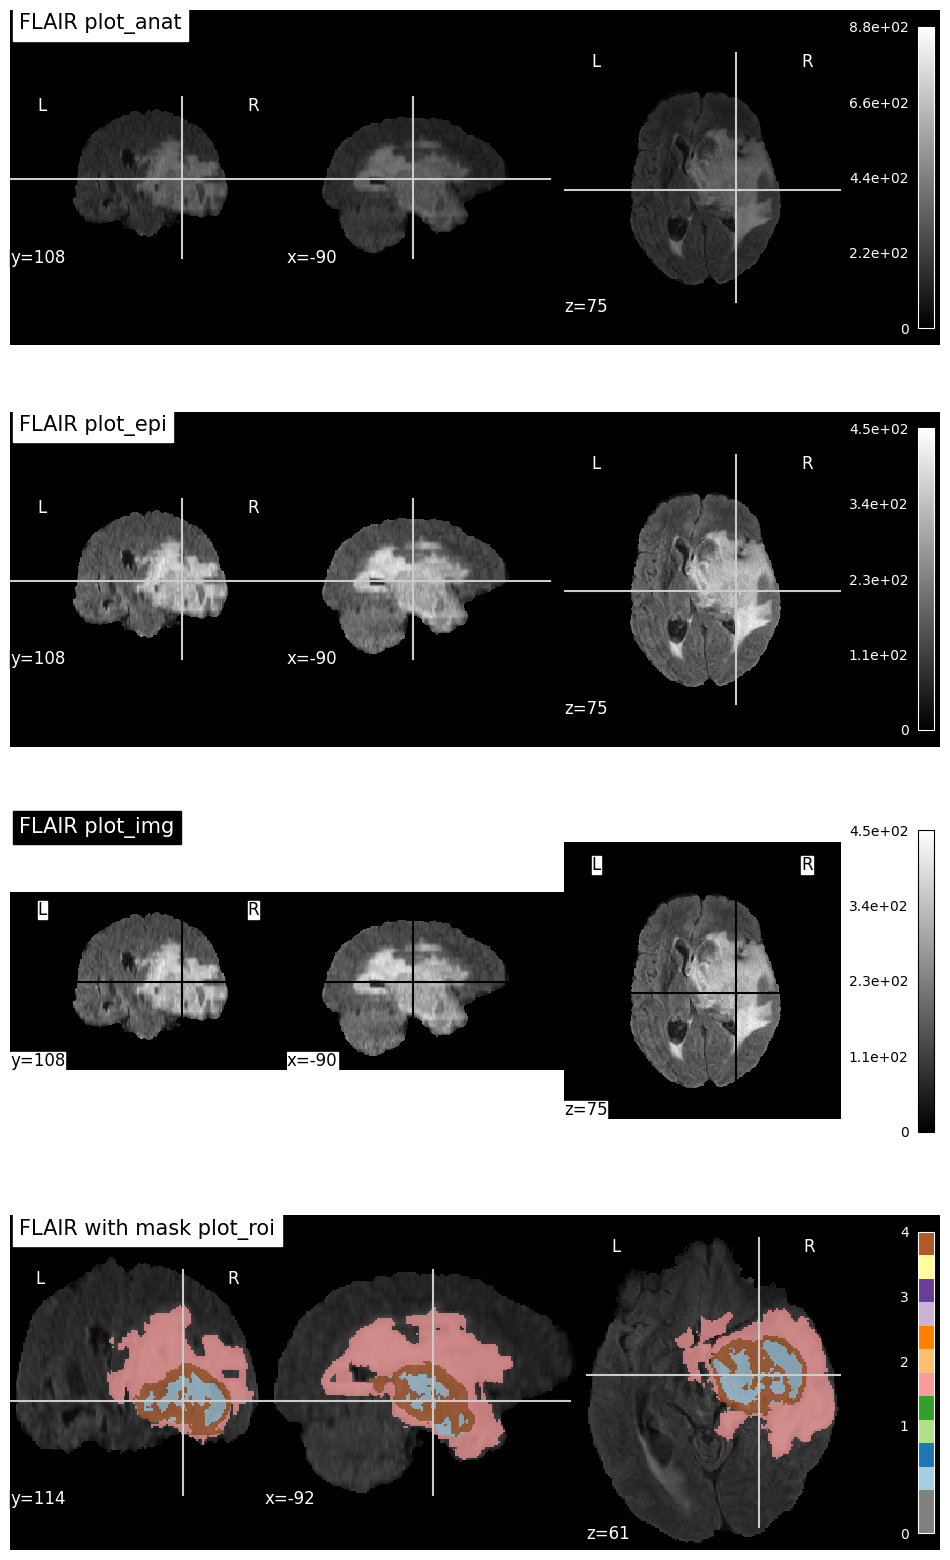

In [25]:
import os
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn.image as nl
import nilearn.plotting as nlplt

TRAIN_DATASET_PATH = r"C:\Users\Niran\Datasets\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"

# Load NIfTI files
niimg_path = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001', 'BraTS20_Training_001_flair.nii')
nimask_path = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001', 'BraTS20_Training_001_seg.nii')

niimg = nl.image.load_img(niimg_path)
nimask = nl.image.load_img(nimask_path)

# Create subplots
fig, axes = plt.subplots(nrows=4, figsize=(12, 20))

# Plot anatomical view
nlplt.plot_anat(niimg,
                title='FLAIR plot_anat',
                axes=axes[0])

# Plot EPI view
nlplt.plot_epi(niimg,
               title='FLAIR plot_epi',
               axes=axes[1])

# Plot generic image
nlplt.plot_img(niimg,
               title='FLAIR plot_img',
               axes=axes[2])

# Overlay ROI (mask) on top of FLAIR
nlplt.plot_roi(nimask,
               title='FLAIR with mask plot_roi',
               bg_img=niimg,
               axes=axes[3], cmap='Paired')

plt.show()


In [26]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [27]:
IMG_SIZE=128

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Build U-Net as before
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool)
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(drop5))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    up = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(conv9))
    merge = concatenate([conv1, up], axis=3)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation='softmax')(conv)

    return Model(inputs=inputs, outputs=conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

# Compile the model (make sure your custom metrics are defined)
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)


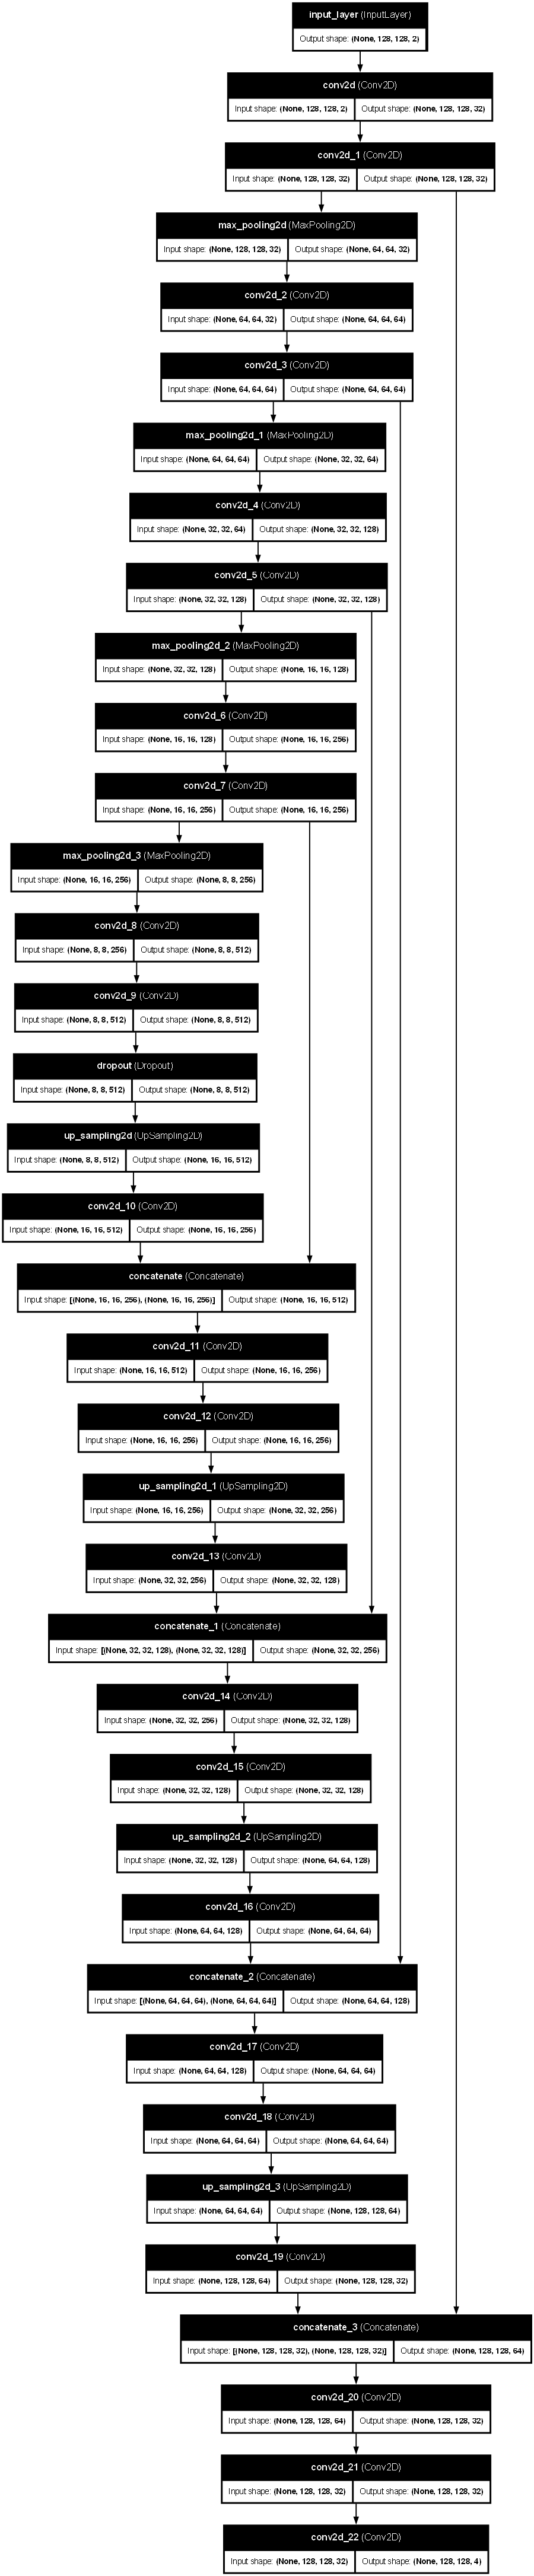

In [29]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [30]:
print(model.summary())
print("TF version:", tf.__version__)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        608 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 8, 512) │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │    524,544 │ up_sampling2d[0]

 Total params: 7,759,908 (29.60 MB)

 Trainable params: 7,759,908 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

None
TF version: 2.20.0


In [31]:
import os
from sklearn.model_selection import train_test_split

# ✅ Local dataset path
TRAIN_DATASET_PATH = r"C:\Users\Niran\Datasets\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"

# List of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# Remove the folder with ill-formatted seg.nii
train_and_val_directories = [d for d in train_and_val_directories if not d.endswith('BraTS20_Training_355')]

# Convert directory paths to IDs
def pathListIntoIds(dirList):
    x = []
    for d in dirList:
        # Use os.path.basename to get the folder name
        x.append(os.path.basename(d))
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories)

# Split into train, validation, and test
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)



In [32]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

C:\Users\Niran\AppData\Local\Temp\ipykernel_560\3393184119.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


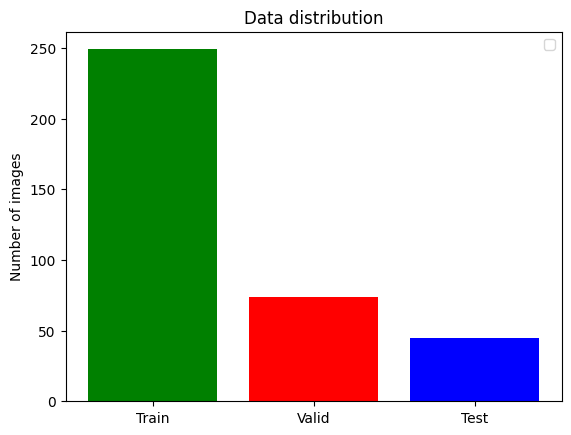

In [33]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

C:\Users\Niran\AppData\Local\Temp\ipykernel_560\74557883.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


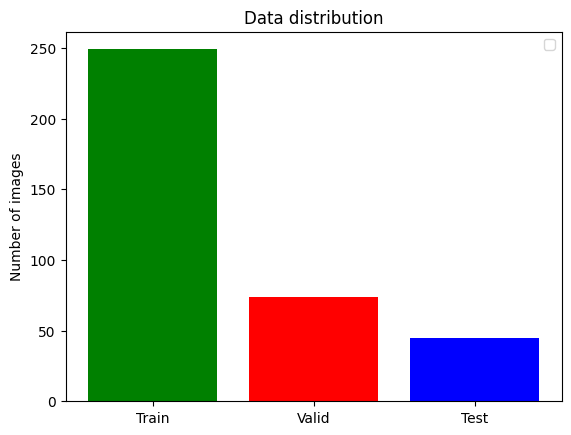

In [34]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [35]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

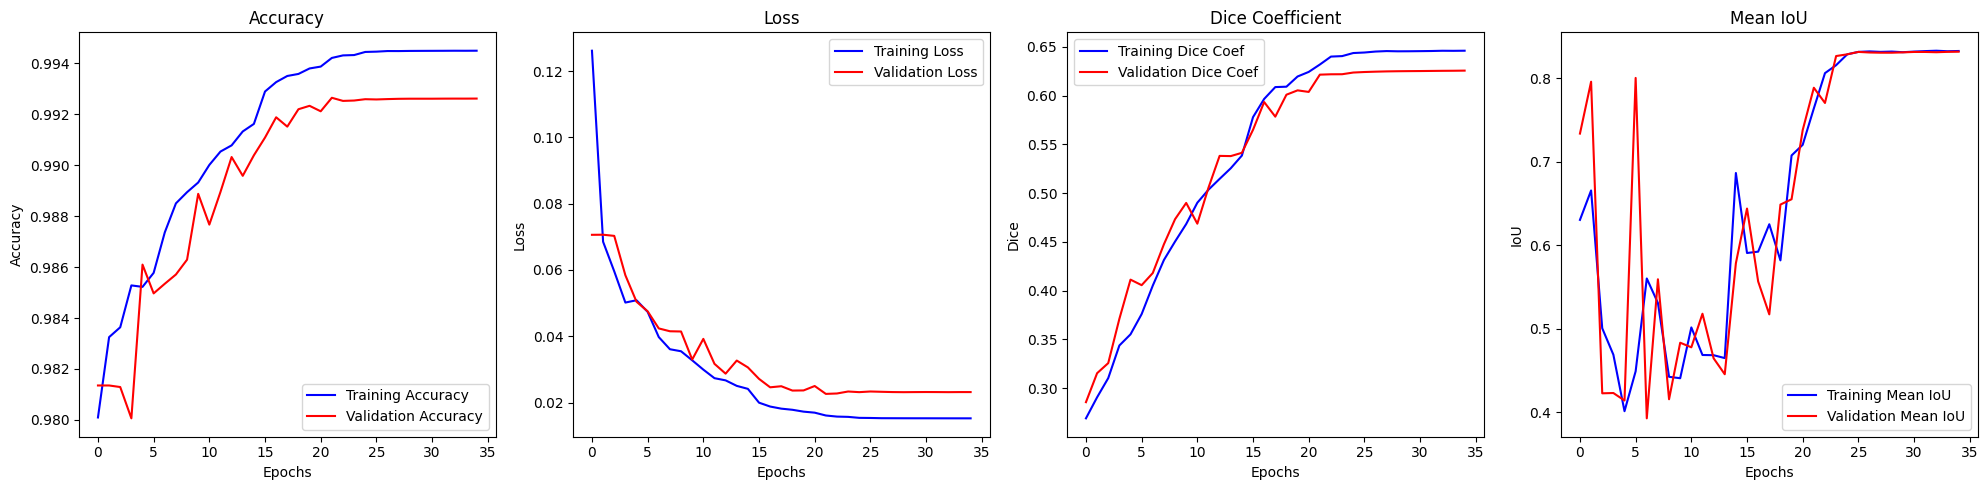

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Load trained model
model = keras.models.load_model(
    r'C:\Users\Niran\Datasets\model_per_class.h5',  # change path to your local model
    custom_objects={
        'accuracy': tf.keras.metrics.MeanIoU(num_classes=4),
        "dice_coef": dice_coef,
        "precision": precision,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "dice_coef_necrotic": dice_coef_necrotic,
        "dice_coef_edema": dice_coef_edema,
        "dice_coef_enhancing": dice_coef_enhancing
    },
    compile=False
)

# Load training history CSV
history = pd.read_csv(r'C:\Users\Niran\Datasets\training_per_class.log', sep=',', engine='python')

# Extract metrics
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
train_dice = history['dice_coef']
val_dice = history['val_dice_coef']
mean_iou = history['mean_io_u']
val_mean_iou = history['val_mean_io_u']

epochs = range(len(acc))

# Plot metrics
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Accuracy
ax[0].plot(epochs, acc, 'b', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

# Loss
ax[1].plot(epochs, loss, 'b', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation Loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

# Dice Coefficient
ax[2].plot(epochs, train_dice, 'b', label='Training Dice Coef')
ax[2].plot(epochs, val_dice, 'r', label='Validation Dice Coef')
ax[2].set_title('Dice Coefficient')
ax[2].legend()
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Dice')

# Mean IoU
ax[3].plot(epochs, mean_iou, 'b', label='Training Mean IoU')
ax[3].plot(epochs, val_mean_iou, 'r', label='Validation Mean IoU')
ax[3].set_title('Mean IoU')
ax[3].legend()
ax[3].set_xlabel('Epochs')
ax[3].set_ylabel('IoU')

plt.tight_layout()
plt.show()


In [37]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


<Figure size 1800x5000 with 0 Axes>

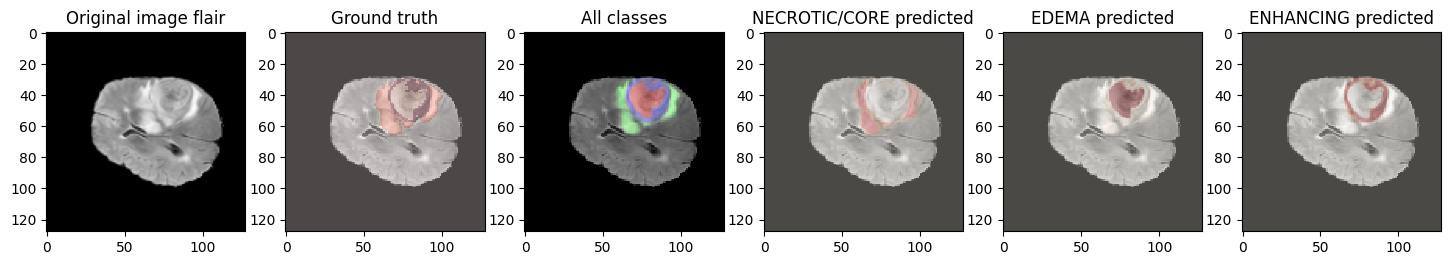

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step


<Figure size 1800x5000 with 0 Axes>

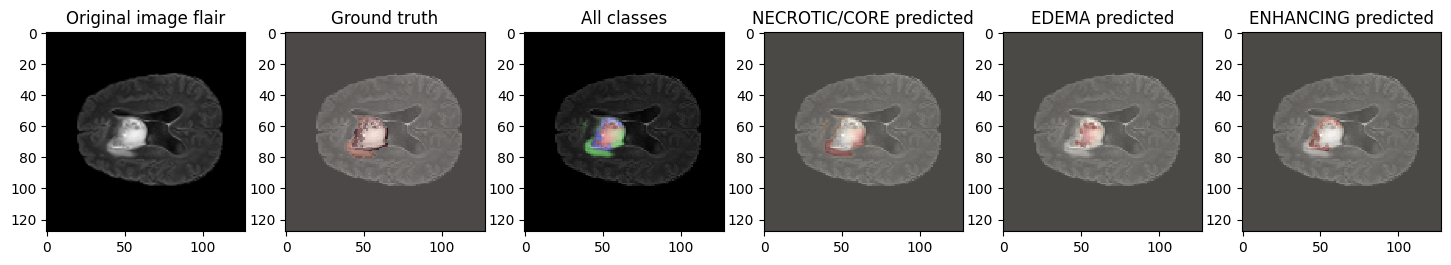

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step


<Figure size 1800x5000 with 0 Axes>

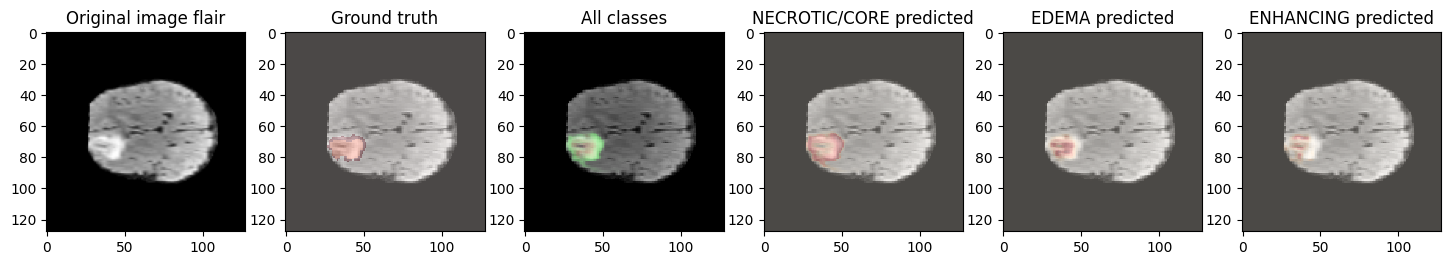

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step


<Figure size 1800x5000 with 0 Axes>

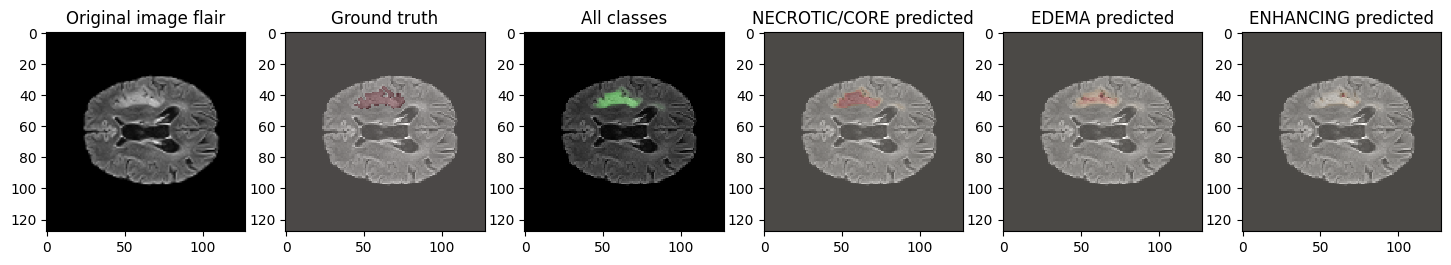

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step


<Figure size 1800x5000 with 0 Axes>

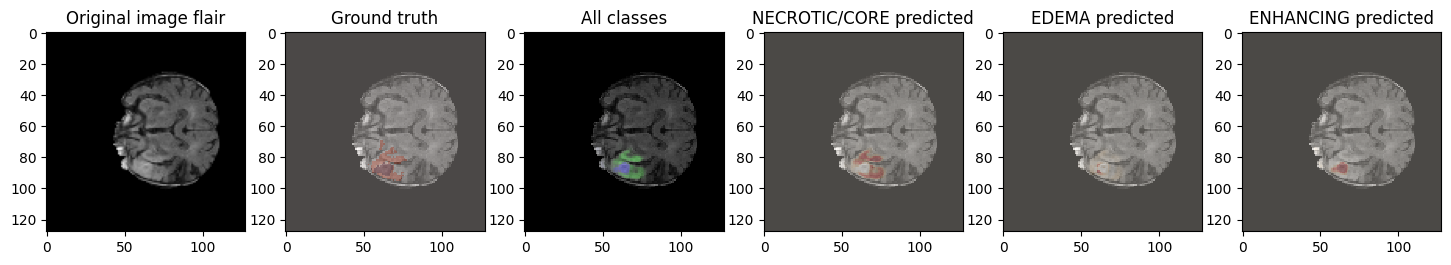

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step


<Figure size 1800x5000 with 0 Axes>

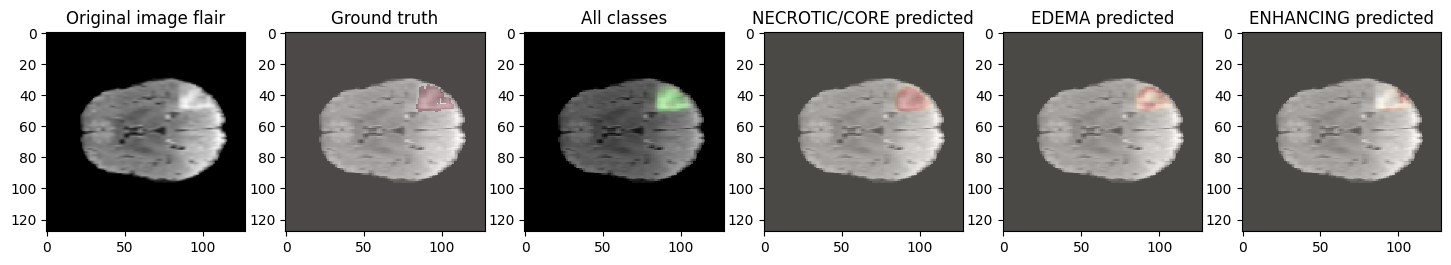

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step


<Figure size 1800x5000 with 0 Axes>

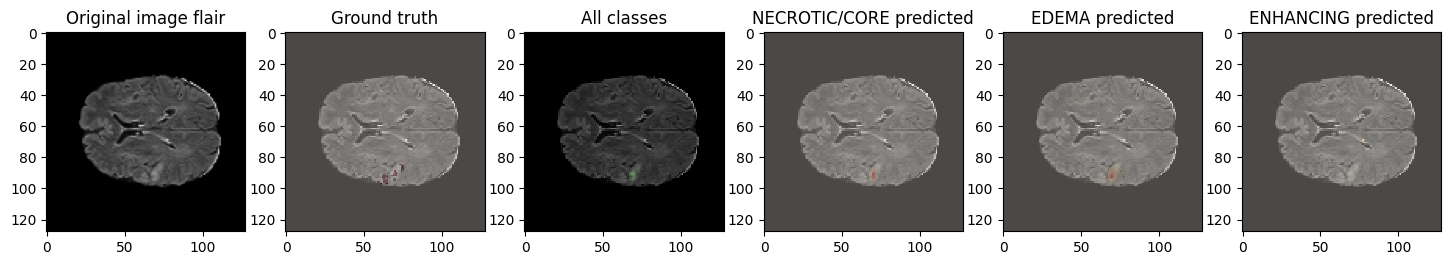

In [38]:
import os
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Set your local dataset path
TRAIN_DATASET_PATH = r"C:\Users\Niran\Datasets\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"

def predictByPath(case_path, case):
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    flair_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    ce_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')

    flair = nib.load(flair_path).get_fdata()
    ce = nib.load(ce_path).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    return model.predict(X / np.max(X), verbose=1)


def showPredictsById(case, start_slice=60):
    path = os.path.join(TRAIN_DATASET_PATH, f'BraTS20_Training_{case}')

    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case)

    core = p[:,:,:,1]
    edema = p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].set_title('Original image flair')

    curr_gt = cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].set_title('Ground truth')

    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].set_title('All classes')

    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].set_title(f'{SEGMENT_CLASSES[1]} predicted')

    axarr[4].imshow(core[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].set_title(f'{SEGMENT_CLASSES[2]} predicted')

    axarr[5].imshow(enhancing[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].set_title(f'{SEGMENT_CLASSES[3]} predicted')

    plt.show()


# Example usage
for i in range(7):
    showPredictsById(case=test_ids[i][-3:])


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step


<Figure size 640x480 with 0 Axes>

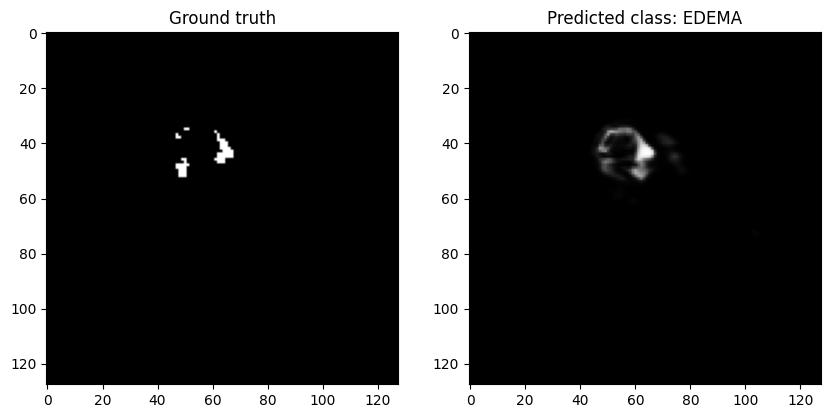

In [39]:
import os
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Your local dataset path
TRAIN_DATASET_PATH = r"C:\Users\Niran\Datasets\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"

# Select case
case = test_ids[3][-3:]
path = os.path.join(TRAIN_DATASET_PATH, f'BraTS20_Training_{case}')

# Load ground truth
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()

# Run prediction
p = predictByPath(path, case)

core = p[:,:,:,1]
edema = p[:,:,:,2]
enhancing = p[:,:,:,3]

# Choose slice and class
i = 40  # slice number
eval_class = 2  # 0: NOT tumor, 1: ENHANCING, 2: CORE, 3: WHOLE

# Prepare ground truth mask for the selected class
gt_class = np.copy(gt)
gt_class[gt_class != eval_class] = 0
gt_class[gt_class == eval_class] = 1

resized_gt = cv2.resize(gt_class[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

# Plot ground truth vs predicted mask
plt.figure()
f, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].set_title('Ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].set_title(f'Predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()


In [43]:
import keras
import tensorflow as tf
from tensorflow.keras import backend as K

In [44]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
45/45 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9938 - dice_coef: 0.6442 - dice_coef_edema: 0.7851 - dice_coef_enhancing: 0.6715 - dice_coef_necrotic: 0.6409 - loss: 0.0180 - mean_io_u_4: 0.8339 - precision: 0.9942 - sensitivity: 0.9924 - specificity: 0.9980
test loss, test acc: [0.01798652671277523, 0.9938221573829651, 0.8338605761528015, 0.6442022323608398, 0.9942247867584229, 0.9923797845840454, 0.9980478286743164, 0.6409238576889038, 0.7850715517997742, 0.6714789271354675]


In [46]:
model_save_path_keras = r"C:\Users\Niran\PyCharmProjects\brats\brain_tumor_model.keras"
model.save(model_save_path_keras)


In [47]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# If you used custom metrics/losses, include them
custom_objects = {
    'dice_coef': dice_coef,
    'precision': precision,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'dice_coef_necrotic': dice_coef_necrotic,
    'dice_coef_edema': dice_coef_edema,
    'dice_coef_enhancing': dice_coef_enhancing
}

model = load_model(
    r"C:\Users\Niran\PyCharmProjects\brats\brain_tumor_model.h5",
    custom_objects=custom_objects
)


In [48]:
import nibabel as nib
import numpy as np

nii_path = r"C:\Users\Niran\Datasets\BraTS2020_ValidationData\MICCAI_BraTS2020_ValidationData\BraTS20_Validation_005\BraTS20_Validation_005_flair.nii"
nii_img = nib.load(nii_path)
img_data = nii_img.get_fdata()  # shape: [H, W, D]
print("Original MRI shape:", img_data.shape)


Original MRI shape: (240, 240, 155)


In [50]:
from skimage.transform import resize

TARGET_H, TARGET_W = 256, 256
slices = []

for i in range(img_data.shape[2]):
    slice_img = img_data[:, :, i]
    slice_img = np.nan_to_num(slice_img, nan=0.0)  # replace NaNs
    max_val = np.max(slice_img)
    if max_val > 0:
        slice_img = slice_img / max_val
    # else slice remains zeros

    slice_img_resized = resize(
        slice_img,
        (TARGET_H, TARGET_W),
        mode='constant',
        preserve_range=True,
        anti_aliasing=True
    )
    slice_img_resized = np.expand_dims(slice_img_resized, axis=-1)
    slices.append(slice_img_resized)

slices_np = np.array(slices)


In [51]:
slices_np = np.repeat(slices_np, 3, axis=-1)  # [num_slices, H, W, 3]


In [53]:
from skimage.transform import resize
import numpy as np

TARGET_H, TARGET_W = 128, 128
slices = []

for i in range(img_data.shape[2]):
    slice_img = img_data[:, :, i]
    slice_img = np.nan_to_num(slice_img, nan=0.0)
    max_val = np.max(slice_img)
    if max_val > 0:
        slice_img = slice_img / max_val

    slice_img_resized = resize(slice_img, (TARGET_H, TARGET_W), mode='constant', preserve_range=True, anti_aliasing=True)
    slice_img_resized = np.expand_dims(slice_img_resized, axis=-1)

    # Ensure 2 channels as the model expects
    slice_img_resized = np.concatenate([slice_img_resized, slice_img_resized], axis=-1)

    slices.append(slice_img_resized)

slices_np = np.array(slices)
print("Shape of input to model:", slices_np.shape)  # should be (num_slices, 128, 128, 2)


Shape of input to model: (155, 128, 128, 2)


In [54]:
preds = model.predict(slices_np, batch_size=4)
pred_masks = np.argmax(preds, axis=-1)


39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step


In [55]:
print(model.input_shape)


(None, 128, 128, 2)


In [56]:
masks_resized = []
for i in range(pred_masks.shape[0]):
    mask = pred_masks[i]
    mask_orig_size = resize(mask, (img_data.shape[0], img_data.shape[1]), order=0, preserve_range=True, anti_aliasing=False)
    masks_resized.append(mask_orig_size)

masks_resized = np.array(masks_resized)  # [num_slices, H_orig, W_orig]


In [57]:
# Transpose to original orientation
masks_resized = np.transpose(masks_resized, (1, 2, 0))  # [H, W, D]

# Save NIfTI
mask_nii = nib.Nifti1Image(masks_resized.astype(np.uint8), affine=nii_img.affine)
output_path = r"C:\Users\Niran\PyCharmProjects\brats\BraTS20_Validation_005_mask.nii"
nib.save(mask_nii, output_path)

print(f"Segmented tumor mask saved at: {output_path}")


Segmented tumor mask saved at: C:\Users\Niran\PyCharmProjects\brats\BraTS20_Validation_005_mask.nii


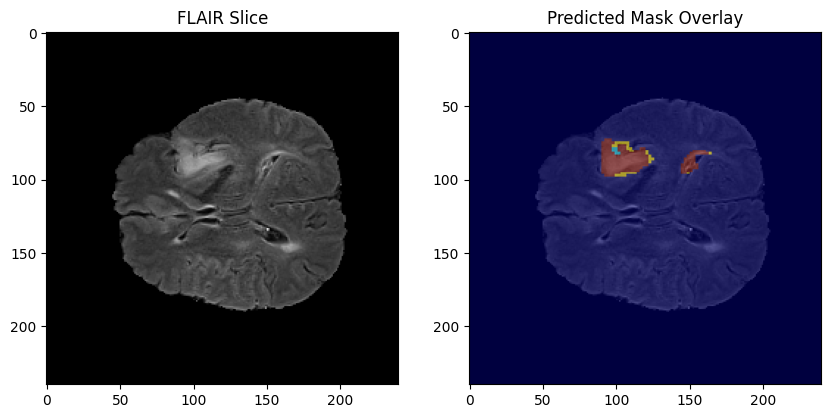

In [58]:
import matplotlib.pyplot as plt

slice_idx = img_data.shape[2] // 2  # middle slice
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("FLAIR Slice")
plt.imshow(img_data[:,:,slice_idx], cmap='gray')
plt.subplot(1,2,2)
plt.title("Predicted Mask Overlay")
plt.imshow(img_data[:,:,slice_idx], cmap='gray')
plt.imshow(masks_resized[:,:,slice_idx], cmap='jet', alpha=0.5)
plt.show()
